<a href="https://colab.research.google.com/github/Claudio9701/pythonAnalyticsBootcamp/blob/master/src/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Probando uso de notebooks dentro de una repo de GH en Googla Colab 👍🏽

In [1]:
import datetime # Tipo de dato para fechas y horas
import pandas as pd # Manejo de datos tabulados
import numpy as np # Algebra Lineal y operaciones matematicas
import matplotlib.pyplot as plt # Graficos de datos
import seaborn as sns # Graficos estadisticos
import pandas_profiling as ppr # ?????????
import geopandas as gpd # Pandas para datos geograficos (Mapas!!)
from fitter import Fitter # Ajuste de distribuciones de probs

In [2]:
%matplotlib inline

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
# Leemos los datos seleccionados
df_main = pd.read_csv('../data/TB_HOSP_VAC_FALLECIDOS.csv')
df_oxigen = pd.read_csv('../data/Oxigeno_25-10-2021.csv', sep="|")
df_camas = pd.read_csv('../data/Camas-08_03_2022.csv', sep="|")

In [5]:
# Validar integridad del identificador "único"
len(df_main['id_persona'].unique()), df_main.shape[0]

(135958, 136422)

In [6]:
# Nulos en id_persona
df_main['id_persona'].isna().sum()

0

In [7]:
# Conteo de cuantas veces se duplican los id_persona
filtro_duplicados = df_main['id_persona'].duplicated(keep=False)
df_main[filtro_duplicados]['id_persona'].value_counts().head()

26422634    3
6054506     3
29048330    3
3820273     2
9985143     2
Name: id_persona, dtype: int64

In [8]:
# TODO: Crear variable si fue reinfeccion (0, 1)
# TODO: Crear variable con el # de la reinfeccion (1, 2, etc)

In [9]:
# Numero de valores perdidos / missings
edad_na_count = df_main['edad'].isna().sum()
print(edad_na_count)
print(round(edad_na_count / df_main.shape[0] * 100, 2), '%')

7843
5.75 %


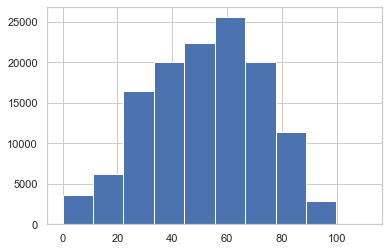

In [10]:
df_main['edad'].hist()
plt.show()

In [11]:
df_main['edad'].describe()

count    128579.000000
mean         52.179446
std          20.436026
min           0.000000
25%          37.000000
50%          54.000000
75%          68.000000
max         111.000000
Name: edad, dtype: float64

In [12]:
counts, bins = np.histogram(df_main['edad'].dropna().values, bins=7)
bins

array([  0.        ,  15.85714286,  31.71428571,  47.57142857,
        63.42857143,  79.28571429,  95.14285714, 111.        ])

In [13]:
rangos_edad = [0, 5, 13, 18, 25, 40, 55, 65, 80, 95, 112]
edad_bins = pd.cut(df_main['edad'], bins=rangos_edad)

edad_bins_count = edad_bins.value_counts()

In [14]:
edad_bins_count

(40, 55]     29595
(65, 80]     26201
(25, 40]     25404
(55, 65]     23376
(80, 95]      9954
(18, 25]      7492
(5, 13]       2197
(13, 18]      1938
(0, 5]        1926
(95, 112]      451
Name: edad, dtype: int64

<AxesSubplot:>

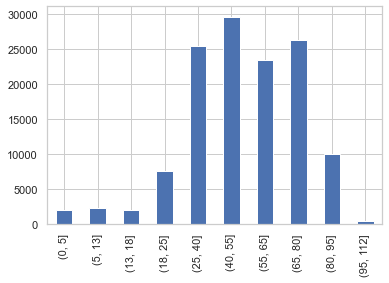

In [15]:
edad_bins_count.sort_index().plot(kind='bar')

In [16]:
df_main['edad_bins'] = edad_bins

In [17]:
# Valores perdidos / missings
df_main['sexo'].isna().sum(), df_main['sexo'].isna().sum() / df_main.shape[0]

(6840, 0.05013854070457844)

In [18]:
df_main['sexo'].value_counts(), df_main['sexo'].value_counts(normalize=True)

(M    69149
 F    60433
 Name: sexo, dtype: int64,
 M    0.533631
 F    0.466369
 Name: sexo, dtype: float64)

In [19]:
conteo_edad_x_sexo = (df_main[['edad_bins', 'sexo']].dropna() # Seleccion de columna y elimino NaNs
                      .groupby(['edad_bins', 'sexo']).size() # Agrupo y cuento las obs. por intervalo de edad y sexo 
                      .reset_index() # Convierte a df 
                      .rename({0: 'conteo'}, axis=1)) # Cambia el nombre de "0" a "conteo"
conteo_edad_x_sexo.head()

,edad_bins,sexo,conteo
0,"(0, 5]",F,850
1,"(0, 5]",M,1076
2,"(5, 13]",F,927
3,"(5, 13]",M,1270
4,"(13, 18]",F,1310


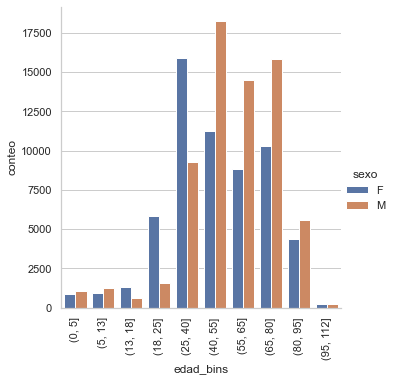

In [20]:
# Gráfica de barras de cantidad de personas por intervalo de edad en cada género
g = sns.catplot(
    data=conteo_edad_x_sexo, kind="bar",
    x="edad_bins", y="conteo", hue="sexo",
)
g.set_xticklabels(rotation=90)
plt.show()

In [21]:
geo_vars = ['ubigeo_inei_domicilio', 'dep_domicilio', 'prov_domicilio', 'dist_domicilio']
df_main[geo_vars].head()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
0,80101,CUSCO,CUSCO,CUSCO
1,150101,LIMA,LIMA,LIMA
2,150801,LIMA,HUAURA,HUACHO
3,140101,LAMBAYEQUE,CHICLAYO,CHICLAYO
4,150101,LIMA,LIMA,LIMA


In [22]:
df_main['ubigeo_inei_domicilio'] = df_main['ubigeo_inei_domicilio'].astype(str)

In [23]:
# Conteo de valores nulos para varias variables
df_main[geo_vars].isna().sum()

ubigeo_inei_domicilio    0
dep_domicilio            0
prov_domicilio           0
dist_domicilio           0
dtype: int64

In [24]:
df_main[geo_vars].describe()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
count,136422,136422,136422,136422
unique,1716,25,196,1580
top,150142,LIMA,LIMA,VILLA EL SALVADOR
freq,7156,50719,46309,7156


In [25]:
gdf_deps = gpd.read_file('../data/LIMITE_DEPARTAMENTAL.zip')
gdf_provs = gpd.read_file('../data/LIMITE_PROVINCIAL.zip')
gdf_dists = gpd.read_file('../data/LIMITE_DISTRITAL.zip')

<AxesSubplot:>

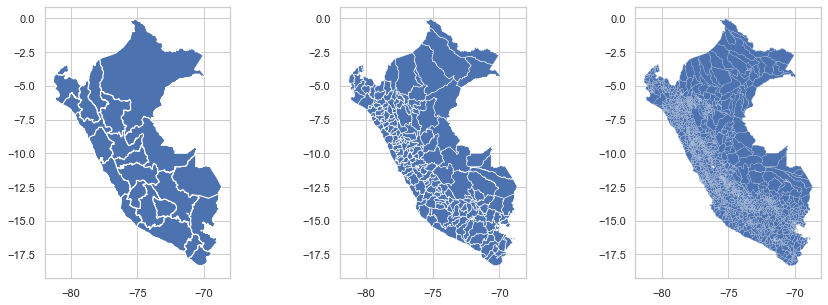

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 5))

gdf_deps.plot(ax=ax1)
gdf_provs.plot(linewidth=0.5, ax=ax2)
gdf_dists.plot(linewidth=0.1, ax=ax3)

In [27]:
# VALIDAMOS QUE LOS NOMBRES DE DEPARTAMENTOS
# EN LOS DOS DATASETS SEAN IGUALES
df_unique_dep = df_main['dep_domicilio'].unique()
df_unique_dep.sort()

gdf_unique_dep = gdf_deps['NOMBDEP'].unique()
gdf_unique_dep.sort()

(df_unique_dep == gdf_unique_dep).all() # True


True

In [28]:
# Contamos la cantidad de hospitalizados por departamento
conteo_x_dept = df_main['dep_domicilio'].value_counts()
conteo_x_dept = conteo_x_dept.reset_index()
conteo_x_dept.head()

,index,dep_domicilio
0,LIMA,50719
1,ANCASH,11753
2,CUSCO,10952
3,CAJAMARCA,8584
4,PIURA,7909


In [29]:
# Unimos los conteos utilizando los nombres de departamentos
gdf_conteo_x_dept = pd.merge(left=gdf_deps, right=conteo_x_dept, 
                             left_on="NOMBDEP", right_on='index')

<AxesSubplot:>

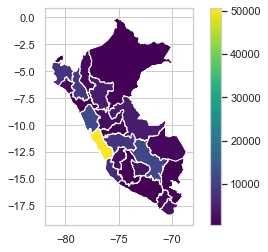

In [30]:
# Mapa de calor de # de hospitalizados x departamento
gdf_conteo_x_dept.plot("dep_domicilio", cmap='viridis',
                       legend=True)

In [31]:
# 1 punto mas para Evelyn!

## Correlación

Es el valor numérico que describe la relación (directa o inversa) entre 2 variables.

In [32]:
# Construir variable tiempo de hospitalizacion por covid
df_main['fecha_ingreso_hosp_dt'] = pd.to_datetime(df_main['fecha_ingreso_hosp'], format="%d/%m/%Y")
df_main['fecha_segumiento_hosp_ultimo_dt'] = pd.to_datetime(df_main['fecha_segumiento_hosp_ultimo'], format="%d/%m/%Y")

In [33]:
dias_hosp = df_main['fecha_segumiento_hosp_ultimo_dt'] - df_main['fecha_ingreso_hosp_dt']
dias_hosp.head()

0    9 days
1    8 days
2   38 days
3    7 days
4    4 days
dtype: timedelta64[ns]

In [34]:
# De segundos a dias
dias_hosp = dias_hosp.dt.total_seconds() / 60 / 60 / 24

In [35]:
df_main['dias_delta_hosp'] = dias_hosp

In [36]:
df_main['dias_delta_hosp'].corr(df_main['edad'])

0.13190281441847826

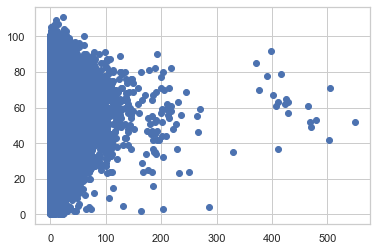

In [37]:
plt.scatter(x=df_main['dias_delta_hosp'], y=df_main['edad'])

In [38]:
corr_matrix_var = ['edad', 'flag_uci', 'cdc_positividad',
 'cdc_fallecido_covid', 'dias_delta_hosp']

In [39]:
len(corr_matrix_var)

5

In [40]:
corr_matrix  = df_main[corr_matrix_var].corr()
corr_matrix

,edad,flag_uci,cdc_positividad,cdc_fallecido_covid,dias_delta_hosp
edad,1.000000,0.031786,0.121101,0.418936,0.131903
flag_uci,0.031786,1.000000,0.042261,0.103393,0.316679
cdc_positividad,0.121101,0.042261,1.000000,0.091382,0.096393
cdc_fallecido_covid,0.418936,0.103393,0.091382,1.000000,-0.028707
dias_delta_hosp,0.131903,0.316679,0.096393,-0.028707,1.000000


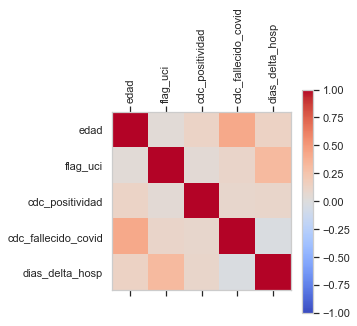

In [41]:
# Grafico de la matriz de correlacion

plt.rcParams['axes.grid'] = False  # Eliminar lineas dentro del grafico

plt.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Colocar nombres de variables en los ejes
plt.xticks(np.arange(corr_matrix.shape[0]), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(corr_matrix.shape[0]), corr_matrix.columns)

plt.colorbar() # Agregar un barra de colores como leyenda

plt.show()

## Analisis Exploratorio de Datos

EDA, por sus siglas en inglés, es el proceso de limpieza y descubrimiento de *insights* a través de la revisión detallada de un conjunto de datos.

### Pasos de preparación

1. Seleccionar las variables a analizar (que sean relevantes para el estudio)
1. Verificar la integridad de las variables (si están limpias o qué debemos hacer para limpiarlas o si no se pueden usar)
1. Plantearse preguntas de exploración
1. Plantear hipotesis a partir de nuestras variables*

### Pasos de EDA 

1. Limpiar los datos (80% del tiempo)
1. Responder las preguntas de exploración a partir de los datos (indicadores y gráficas)
1. Responder las hipótesis (Tests estadísticos | estadística descriptiva)*
1. Generar un reporte de resultados para el público en general 

> *Pasos opcionales dependiendo de la experiencia en el area de analisis

In [42]:
profile = ppr.ProfileReport(df_main, title='Pandas Profiling Report', minimal=True)

In [43]:
profile.to_file('../data/reports/TB_HOSP_VAC_FALLECIDOS.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 193.17it/s]


### Preguntas de exploración

1. ¿Cuál fue el índice de mortalidad por grupo de edad?
1. ¿Cuál es el % de pacientes UCI vacunados con la 1, 2 o 3 dosis?
1. ¿Cuál es la edad promedio de las personas que ingresaron a UCI?
1. ¿Cuál fue el tiempo promedio de recuperación de las personas que lograron salir de UCI?

In [44]:
filtro_inicio_pandemia = df_main['fecha_ingreso_hosp_dt'] > datetime.datetime(2020, 3, 6)
df_main_filtrado = df_main[filtro_inicio_pandemia]

In [45]:
# Índice de mortalidad por grupo de edad
# Muestra: Personas hospitalizadas entre 2020-03-16 al 2022-03-08
# Formula: # personas fallecidas entre X y Y años / Total de personas hospitalizadas entre X y Y años
num_fallecidos_x_edad = df_main_filtrado.groupby(['cdc_fallecido_covid', 'edad_bins']).size()
num_fallecidos_x_edad

cdc_fallecido_covid  edad_bins
0                    (0, 5]        1869
                     (5, 13]       2159
                     (13, 18]      1891
                     (18, 25]      7332
                     (25, 40]     23733
                     (40, 55]     23095
                     (55, 65]     14735
                     (65, 80]     12972
                     (80, 95]      4175
                     (95, 112]      148
1                    (0, 5]          57
                     (5, 13]         38
                     (13, 18]        47
                     (18, 25]       160
                     (25, 40]      1671
                     (40, 55]      6498
                     (55, 65]      8641
                     (65, 80]     13227
                     (80, 95]      5778
                     (95, 112]      303
dtype: int64

In [46]:
total_hosp = df_main_filtrado.groupby('edad_bins').size()
total_hosp

edad_bins
(0, 5]        1926
(5, 13]       2197
(13, 18]      1938
(18, 25]      7492
(25, 40]     25404
(40, 55]     29593
(55, 65]     23376
(65, 80]     26199
(80, 95]      9953
(95, 112]      451
dtype: int64

In [47]:
perc_fallecidos_x_edad = num_fallecidos_x_edad.loc[1] / total_hosp * 100
perc_fallecidos_x_edad

edad_bins
(0, 5]        2.959502
(5, 13]       1.729631
(13, 18]      2.425181
(18, 25]      2.135611
(25, 40]      6.577704
(40, 55]     21.957895
(55, 65]     36.965264
(65, 80]     50.486660
(80, 95]     58.052848
(95, 112]    67.184035
dtype: float64

<AxesSubplot:xlabel='edad_bins'>

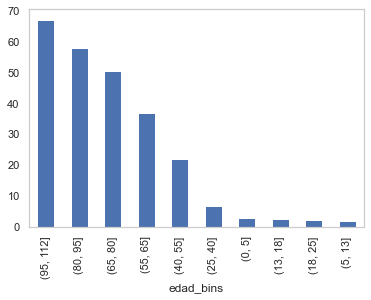

In [48]:
perc_fallecidos_x_edad.sort_values(ascending=False).plot(kind='bar')

In [49]:
# Pacientes UCI vacunados con la 1, 2 o 3 dosis

filtro_uci = df_main_filtrado['flag_uci'] == 1
df_main_filtrado_uci = df_main_filtrado[filtro_uci]

filtro_fechas_vacunacion = df_main_filtrado_uci['fecha_ingreso_hosp_dt'] >= datetime.datetime(2021, 2, 25)
df_main_filtrado_uci = df_main_filtrado_uci[filtro_fechas_vacunacion]

vars_vacuna = ['fecha_dosis1', 'fecha_dosis2', 'fecha_dosis3']


In [50]:
# Conteo de numero de dosis
df_main_filtrado_uci['n_dosis'] = df_main_filtrado_uci[vars_vacuna].notna().sum(axis=1)
# Conteo & porcentaje de pacientes UCI con 0, 1, 2 o 3 dosis 
df_main_filtrado_uci['n_dosis'].value_counts(), df_main_filtrado_uci['n_dosis'].value_counts(normalize=True) * 100

(0    4139
 2    3106
 3    2315
 1     654
 Name: n_dosis, dtype: int64,
 0    40.522812
 2    30.409242
 3    22.664970
 1     6.402976
 Name: n_dosis, dtype: float64)

In [51]:
df_main_filtrado_uci['n_dosis']

6         0
8         0
12        0
22        0
554       3
         ..
136320    0
136337    2
136355    3
136368    2
136412    1
Name: n_dosis, Length: 10214, dtype: int64

In [52]:
# Los valores nulos representan que no se ha colocado la dosis
df_main_filtrado_uci[vars_vacuna].notna()

,fecha_dosis1,fecha_dosis2,fecha_dosis3
6,False,False,False
8,False,False,False
12,False,False,False
22,False,False,False
554,True,True,True
...,...,...,...
136320,False,False,False
136337,True,True,False
136355,True,True,True
136368,True,True,False


In [53]:
# Los valores True o False corresponden a 0 y 1 respectivamente
df_temporal_vacunas = df_main_filtrado_uci[vars_vacuna].notna().astype(int)
df_temporal_vacunas

,fecha_dosis1,fecha_dosis2,fecha_dosis3
6,0,0,0
8,0,0,0
12,0,0,0
22,0,0,0
554,1,1,1
...,...,...,...
136320,0,0,0
136337,1,1,0
136355,1,1,1
136368,1,1,0


In [54]:
# Si sumamos las columnas tendremos el total de dosis por persona
df_temporal_vacunas['cantidad_dosis'] = df_main_filtrado_uci[vars_vacuna].notna().sum(axis=1)
df_temporal_vacunas

,fecha_dosis1,fecha_dosis2,fecha_dosis3,cantidad_dosis
6,0,0,0,0
8,0,0,0,0
12,0,0,0,0
22,0,0,0,0
554,1,1,1,3
...,...,...,...,...
136320,0,0,0,0
136337,1,1,0,2
136355,1,1,1,3
136368,1,1,0,2


In [55]:
# Edad promedio de las pacientes UCI
print('Edad promedio de las pacientes UCI:')
df_main_filtrado[filtro_uci]['edad'].mean().round(0)

Edad promedio de las pacientes UCI:


54.0

In [56]:
# Tiempo promedio de recuperación de pacientes UCI recuperados
# Muestra: Pacientes que entraron y se recuperaron
# Formula: SUM(Fecha de alta medica - Fecha de ingreso UCI para cada paciente) / # pacientes 
df_main['fecha_ingreso_uci_dt'] = pd.to_datetime(df_main['fecha_ingreso_uci'], format='%d/%m/%Y')

filtro_alta_med = df_main['evolucion_hosp_ultimo'] == 'alta'
df_main_filtro_uci_recuperados = df_main[filtro_inicio_pandemia & filtro_uci & filtro_alta_med]

tiempo_recuperacion_uci = df_main_filtro_uci_recuperados['fecha_segumiento_hosp_ultimo_dt'] - df_main_filtro_uci_recuperados['fecha_ingreso_uci_dt']
print("Tiempo promedio de recuperación de pacientes UCI recuperados:")
tiempo_recuperacion_uci.mean()

Tiempo promedio de recuperación de pacientes UCI recuperados:


Timedelta('23 days 22:39:53.397524071')

In [57]:
df_main['evolucion_hosp_ultimo'].value_counts()

alta               92564
defuncion          35244
referido            3026
alta_voluntaria     2271
estacionario         609
desfavorable         601
favorable            184
Name: evolucion_hosp_ultimo, dtype: int64

### Ejemplos de Test de Hipótesis Estadísticas

Esta guía es un resumen y adapación de [*17 Statistical Hypothesis Tests in Python*](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)

#### Test de Normalidad Shapiro-Wilk

Permite determinar que tan probable que los datos sigan una distribución Normal (Gaussiana). El único supuesto necesario para aplicar este test es que las observaciones de la muestra de datos sean independientes e identicamente distribuidas (iid).


#### ¿Cómo se interpretan los resultados de este test?

Se tienen dos hipotesis: La Hipótesis Nula (H0), que se intenta rechazar, y la Hipótesis Alternativa (H1), que se intenta comprobar.

- H0: La muestra tiene una distribucion Normal. Se rechaza si $p$ < 0.05
- H1: La muestra **NO** tiene una distribucion Normal. Se rechaza si $p$ > 0.05


Veamos la implementación desde python:


In [85]:
from scipy.stats import shapiro

In [123]:
edad = df_main_filtrado['edad'].dropna()
edad.shape

(128574,)

In [124]:
# N > 5000 el valor de p no es preciso, por ello seleccionemos 45000 observaciones aleatoriamente
edad = edad.sample(4500) 

In [125]:
stat, p = shapiro(edad)
print(f'stat={stat:.3f}, p={p:.3f}')

stat=0.989, p=0.000


In [127]:
if p > 0.05:
	print('Se acepta la H0. La muestra tiene una distribucion Normal.')
else:
	print('Se rechaza la H0. La muestra NO tiene una distribucion Normal')

Se rechaza la H0. La muestra NO tiene una distribucion Normal



#### Chi-Squared Test

Este test te permite determinar si es probable que dos variables categóricas están relacionadas o son independientes entre sí. Para que este test sea válido se necesita cumplir con 2 supuestos. 1) Las observaciones utilizadas para calcular la tabla de contingencia son independientes y 2) Cada valor en la tabla de contingenia debe ser mayor a 25.

#### ¿Qué es una tabla de contingencia?

Es una tabla de cruzada de frecuencia de dos observaciones categoricas. Como en el siguiente ejemplo:

| Sexo / Flag_UCI | 0   | 1  | Total |
|-----------------|-----|----|-------|
| **M**               | 54  | 32 | 86    |
| **F**               | 68  | 34 | 102   |
| **Total**           | 122 | 66 | 188   |

#### ¿Cómo se interpretan los resultados de este test?

- H0: Las dos muestras son independientes. Se rechaza si $p$ < 0.05
- H1: Existe dependencia entre las muestras. Se rechaza si $p$ > 0.05

Veamos la implementación desde python:

In [ ]:
from scipy.stats import chi2_contingency

In [62]:

contingency_table = pd.crosstab(df_main_filtrado['sexo'], df_main_filtrado['flag_uci'])
contingency_table

flag_uci,0,1
sexo,,
F,54584,5848
M,58095,11049


In [128]:
stat, p, dof, expected = chi2_contingency(contingency_table)
print(f'stat={stat:.3f}, p={p:.3f}')

stat=1129.102, p=0.000


In [129]:
if p > 0.05:
	print('Se acepta la H0. Las dos muestras son independientes.')
else:
	print('Se rechaza la H0. Existe dependencia entre las muestras.')

Se rechaza la H0. Existe dependencia entre las muestras.


#### Analisis de Varianza (ANOVA)

Este test te permite determinar si es probable que dos o mas grupos tienen la misma media poblacional. Los supuestos de este test son que las observaciones de cada muestra:

1. Son independientes y identicamente distribuidas (iid).
1. Siguen una distribución normal.
1. Tienen la misma varianza (homocedasticidad).

#### ¿Cómo se interpretan los resultados de este test?

- H0: Las medias poblacionales de los grupos son iguales. Se rechaza si $p$ < 0.05
- H1: Una o más de las medias poblacionales de los grupos son diferentes. Se rechaza si $p$ > 0.05

Veamos la implementación desde python:


In [69]:
from scipy.stats import f_oneway

In [74]:
# Filtrar solo las personas que ingresaron luego del inicio de la vacunación
filtro_fechas_vacunacion = df_main_filtrado['fecha_ingreso_hosp_dt'] >= datetime.datetime(2021, 2, 25)
df_main_filtrado_fechas_vacuna = df_main_filtrado[filtro_fechas_vacunacion].copy()

# Conteo de numero de dosis
vars_vacuna = ['fecha_dosis1', 'fecha_dosis2', 'fecha_dosis3']
df_main_filtrado_fechas_vacuna['n_dosis'] = df_main_filtrado_fechas_vacuna[vars_vacuna].notna().sum(axis=1)

# Muestras (Variable a analizar: Cantidad de dosis)
muestra_no_uci = df_main_filtrado_fechas_vacuna[df_main_filtrado_fechas_vacuna['flag_uci'] == 0]['n_dosis']
muestra_uci = df_main_filtrado_fechas_vacuna[df_main_filtrado_fechas_vacuna['flag_uci'] == 1]['n_dosis']

In [130]:
stat, p = f_oneway(muestra_no_uci, muestra_uci)
print(f'stat={stat:.3f}, p={p:.3f}')

stat=186.488, p=0.000


In [131]:
if p > 0.05:
	print('Se acepta la H0. Las medias poblacionales de los grupos son iguales.')
else:
	print('Se rechaza la H0. Una o más de las medias poblacionales de los grupos son diferente.')

Se rechaza la H0. Una o más de las medias poblacionales de los grupos son diferente.


Ese resultado no era fácil de inferir utilizando solamente el cálculo de la media muestral:

In [82]:
muestra_no_uci.mean(), muestra_uci.mean()

(1.5330759521865023, 1.3521636968866262)